# Session setup

## Libraries

In [98]:
# basic operations
import os
import json
import re
import logging
import time
import pickle

# load data from mongodb
from pymongo import MongoClient

# utilities
from pprint import pprint as pp

# data analysis/management/manipulation
import numpy as np
import pandas as pd
from pandas import json_normalize
import sklearn

# topic modeling
import gensim
from gensim.models import LdaModel, ldamodel
from gensim.models import LsiModel, lsimodel
from gensim.models import ldaseqmodel
from gensim.models import Phrases
from gensim.models import CoherenceModel  
from gensim.corpora import Dictionary
from gensim.similarities import MatrixSimilarity

# nlp pipeline
import spacy
import en_core_web_lg

# multivariate analysis
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA

# distance metrics
from scipy.spatial.distance import cosine

# visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pyLDAvis
import pyLDAvis.gensim

## Options for dumping outcome to the screen

In [99]:
# data vis
%matplotlib inline

# send output to the screen
LINE = ''.join(['\n', 79 * '-', '\n'])

## Dataviz options

In [100]:
plt.style.use('seaborn-bright')

## Basic info about the notebook/session

In [101]:
# check libraries
print(' | '.join(['spaCy Version: %s' % (spacy.__version__),
                  'Gensim Version: %s' % (gensim.__version__),]),
      end=LINE)

# coding style
print('Coding style as per PEP8', '', end=LINE)

spaCy Version: 2.2.4 | Gensim Version: 3.8.3
-------------------------------------------------------------------------------
Coding style as per PEP8 
-------------------------------------------------------------------------------


# Read data

In [102]:
# params
CWD = os.getcwd()
FOLDER = 'data'
FILE = 'press_releases.json'

# reda data
DF = json_normalize([json.loads(line) 
                     for line in open(os.path.join(FOLDER, FILE))])

# slice the data
DF = DF.loc[DF['year'] > 2008]

# Logging Gensim's output

In [103]:
LOG_FILE = os.path.join(CWD, FOLDER, 'log_%s.txt' % time.time())

logging.basicConfig(filename=LOG_FILE,
                    format='%(asctime)s : %(levelname)s : %(message)s',
                    level=logging.INFO)

# Data transformation

## Basic data cleaning

In [104]:
# date as datetime
DF.loc[:, 'date'] = pd.to_datetime(DF['date.$date'])

# get timespans
DF.loc[:, 'year'] = DF['date'].dt.year

# drop column
DF.drop(['date.$date', '_id.$oid'], axis=1, inplace=True)

# remove returns
DF.loc[:, 'text'] = DF['text'].str.replace('\n', '')

## Arrange data for sequential LDA

In [105]:
# order data by year of publication
DF.sort_values('year', inplace=True)

# get stacks by year
DATA = DF.groupby('year').size()

### Time slices

In [106]:
TIME_SLICES = DATA.values
print(TIME_SLICES)

[  97   11   40   21  265  385  479  825 1070  862  327]


### Exploratory chart

In [107]:
# data series
X = DATA.index
Y = TIME_SLICES

# labels
X_LABELS = ['%s' % i for i in X if i < 2019] + ['2019*']
Y_LABELS = ['%s' % i for i in np.arange(0, 1400, 200)]

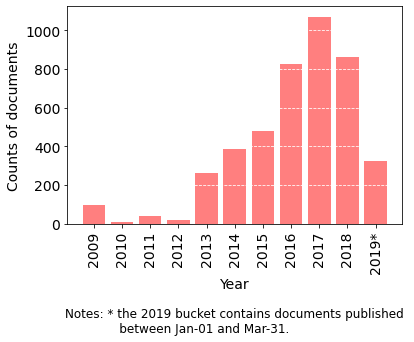

In [108]:
# create figure
PLT = plt.figure(figsize=(6, 4))

# populate figure with a plot
AX = PLT.add_subplot(1, 1, 1)



# plot data
AX.bar(X, Y, color='r', alpha=0.5)

# axis properties
AX.set_xticks(X)
AX.set_xticklabels(X_LABELS, fontsize=14, rotation='vertical')
AX.set_xlabel('Year', fontsize=14)
AX.set_yticklabels(Y_LABELS, fontsize=14)
AX.set_ylabel('Counts of documents', fontsize=14)

# annotation
NOTES = """Notes: * the 2019 bucket contains documents published 
              between Jan-01 and Mar-31."""
PLT.text(0.12, -0.25, NOTES, fontsize=12)

# grid
AX.grid(True, ls='--', axis='y', color='white')

# show plot
PLT.show()

## List to pass through spacy

In [109]:
# list of articles
DOCS = [article.strip().lower() for article in DF.text]

# hyphen to underscores
DOCS = [re.sub(r'\b-\b', '_', text) for text in DOCS]

# Pass documents through spaCy's `nlp` pipeline

## Load language model

In [110]:
# load spaCy model 'web_lg'
nlp = en_core_web_lg.load()

## Expand on spaCy's stopwords

In [112]:
# # params
# CWD = CWD
# FOLDER = FOLDER
# FILE = 'my_stopwords.pickle'

# # load my stopwords from pickle
# with open(os.path.join(CWD, FOLDER, FILE), 'rb') as pipe:
#     MY_STOPWORDS = pickle.load(pipe)

# my stopwrods
MY_STOPWORDS = ['\x1c',
                'ft', 'wsj', 'time', 'sec',
                'say', 'says', 'said',
                'mr.', 'mister', 'mr', 'miss', 'ms',
                'inc']

# expand on spaCy's stopwords 
for stopword in MY_STOPWORDS:
    nlp.vocab[stopword].is_stop = True

## Tokenize text

In [113]:
# filter text
DOCS_TOKENS, TMP_TOKENS = [], []

for doc in DOCS:
    TMP_TOKENS = [token.lemma_ for token in nlp(doc)
                  if not token.is_stop
                  and not token.is_punct
                  and not token.like_num
                  and not token.like_url
                  and not token.like_email
                  and not token.is_currency
                  and not token.is_oov]
    DOCS_TOKENS.append(TMP_TOKENS)
    TMP_TOKENS = []

## Take into account bi- and tri-grams

In [ ]:
# get rid of common terms
COMMON_TERMS = [u'of', u'with', u'without', u'and', u'or', u'the', u'a',
                u'not', 'be', u'to', u'this', u'who', u'in']

# find phrases
BIGRAM = Phrases(DOCS_TOKENS,
                 min_count=50,
                 threshold=5,
                 max_vocab_size=50000,
                 common_terms=COMMON_TERMS)

TRIGRAM = Phrases(BIGRAM[DOCS_TOKENS],
                  min_count=50,
                  threshold=5,
                  max_vocab_size=50000,
                  common_terms=COMMON_TERMS)

# uncomment if bi-grammed, tokenized document is preferred
# DOCS_PHRASED = [BIGRAM[line] for line in DOCS_TOKENS]
DOCS_PHRASED = [BIGRAM[line] for line in DOCS_TOKENS]

# check nlp pipeline
print('',
      'Published article:', DOCS[1][0:1000],
      'Tokenized article:', DOCS_TOKENS[1][1:100],
      'Tri-grammed tokenised article:', DOCS_PHRASED[1][1:100],
      sep=LINE, end=LINE)

# Corpus & dictionary to pass to the Topic Modeling

## Get dictionary and corpus

In [ ]:
# create dictionary and text corpus
'''
overriding these transformations breaks reproducibility
'''
DICT = Dictionary(DOCS_PHRASED)
CORPUS = [DICT.doc2bow(doc) for doc in DOCS_PHRASED]

## Write dictionary and corpus to files

# Keyword analysis

In [ ]:
"""
machine learning
internet of things
robotis
technology
computer science
computers
automation
augmented reality
big data
deep learning
cloud computing
natural language processing
pattern recognition
analytics
computing
"""

# Sequential Topic modeling

## Sequential LDA

In [83]:
# fix the number of topics
N_TOPICS = 10

# model estimation
LDA_SEQ = ldaseqmodel.LdaSeqModel(corpus=CORPUS,
                                 id2word=DICT,
                                 time_slice=TIME_SLICES,
                                 num_topics=N_TOPICS)

IndexError: index 11 is out of bounds for axis 1 with size 11

## Estimation results

### Print topics

In [ ]:
# print topics
LDA_SEQ.print_topics(num_topics=N_TOPICS, num_words=5, time=0)

### Result visualization with pyLDAvis

### Copy the training model weights from `Mallet` to `Gensim`

In [389]:
# translate topic modeling outcome
LDA_MALLET_G = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(LDA_MALLET)

In [390]:
# ignore warnings coming from pyLDAvis
import warnings
warnings.filterwarnings('ignore')

# visualizing the outcome of the retained model -- this takes time
pyLDAvis.enable_notebook()
DATA_VIS = pyLDAvis.gensim.prepare(LDA_MALLET_G, CORPUS, DICT, sort_topics=False)
DATA_VIS

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.137176 -0.073134       1        1   9.868051
1     -0.098397  0.137931       2        1   9.696344
2     -0.130300 -0.226149       3        1  10.486971
3      0.297407  0.084309       4        1  10.138615
4     -0.144736  0.158053       5        1  10.418150
5     -0.045599  0.244126       6        1  10.001669
6     -0.082241 -0.151466       7        1  10.110474
7      0.225939  0.011279       8        1   9.562007
8      0.022695 -0.222757       9        1   9.681441
9     -0.181944  0.037809      10        1  10.036278, topic_info=     Category        Freq              Term       Total  loglift  logprob
89    Default  701.000000       performance  701.000000  30.0000  30.0000
221   Default  565.000000              team  565.000000  29.0000  29.0000
157   Default  480.000000             group  480.000000  28.0000  28.0000
324   Default  420.000000  transformational  420.000000  27.0000  27.0000
74    Default  367.000000          employee  367.000000  26.0000  26.0000
7     Default  325.000000       charismatic  325.000000  25.0000  25.0000
101   Default  383.000000              work  383.000000  24.0000  24.0000
13    Default  303.000000       development  303.000000  23.0000  23.0000
609   Default  298.000000       subordinate  298.000000  22.0000  22.0000
110   Default  269.000000           context  269.000000  21.0000  21.0000
280   Default  263.000000     effectiveness  263.000000  20.0000  20.0000
109   Default  258.000000            change  258.000000  19.0000  19.0000
170   Default  410.000000              role  410.000000  18.0000  18.0000
127   Default  219.000000           manager  219.000000  17.0000  17.0000
299   Default  231.000000               lmx  231.000000  16.0000  16.0000
631   Default  218.000000            member  218.000000  15.0000  15.0000
88    Default  272.000000        perception  272.000000  14.0000  14.0000
615   Default  208.000000            affect  208.000000  13.0000  13.0000
1167  Default  200.000000               ceo  200.000000  12.0000  12.0000
50    Default  199.000000              task  199.000000  11.0000  11.0000
176   Default  195.000000             woman  195.000000  10.0000  10.0000
51    Default  190.000000              time  190.000000   9.0000   9.0000
92    Default  238.000000          positive  238.000000   8.0000   8.0000
14    Default  179.000000           emotion  179.000000   7.0000   7.0000
600   Default  239.000000             level  239.000000   6.0000   6.0000
239   Default  190.000000       perspective  190.000000   5.0000   5.0000
994   Default  176.000000            rating  176.000000   4.0000   4.0000
937   Default  164.000000         emotional  164.000000   3.0000   3.0000
12    Default  234.000000           develop  234.000000   2.0000   2.0000
1051  Default  159.000000          charisma  159.000000   1.0000   1.0000
...       ...         ...               ...         ...      ...      ...
169   Topic10  100.075957          response  101.143500   2.2884  -4.1847
295   Topic10   34.763227       independent   34.763227   2.2990  -5.2421
2519  Topic10   33.709796      extraversion   33.709796   2.2990  -5.2728
1824  Topic10   32.656365          complete   32.656365   2.2990  -5.3046
1504  Topic10   32.656365         dominance   32.656365   2.2990  -5.3046
1548  Topic10   31.602934             score   31.602934   2.2990  -5.3374
967   Topic10   31.602934         selection   31.602934   2.2990  -5.3374
2040  Topic10   30.549503             ideal   30.549503   2.2990  -5.3713
2632  Topic10   30.549503              norm   30.549503   2.2990  -5.3713
3378  Topic10   29.496071          efficacy   29.496071   2.2990  -5.4064
905   Topic10   29.496071   decision_making   29.496071   2.2990  -5.4064
2353  Topic10   28.442640     self_efficacy   28.442640   2.2990  -5.4427
76    Topic10   65.312730      experimental   67.4761

In [391]:
# save pyLDAvis data to json file
pyLDAvis.save_json(DATA_VIS, 'topic_modelling_vis.json')

# Statistical analysis of LDA estimation results

## Get term-to-topic probabilities

In [392]:
# get top 5 terms per topic
TOP_TERMS_LINE = LDA_MALLET_G.show_topics(num_topics=N_TOPICS, num_words=10)

In [393]:
# rearrange data on top 10 terms per topic
TOP_TERMS_M = []

for i in TOP_TERMS_LINE:
    topic_num = i[0]
    prob_terms = i[1].split('+')
    for term_sort, term in enumerate(prob_terms):
        weight = float(term.split('*')[0])
        term = term.split('*')[1].strip('"| ')
        TOP_TERMS_M.append([topic_num, term_sort, weight, term])

DF = pd.DataFrame(TOP_TERMS_M)

# rename columns
OLD_NAMES = [0, 1, 2, 3]
NEW_NAMES = ['topic_n', 'term_sort', 'weight', 'term']
COLS = dict(zip(OLD_NAMES, NEW_NAMES))
DF.rename(columns=COLS, inplace=True)
DF.set_index(['term_sort', 'topic_n'], inplace=True)
DF = DF.unstack()

# sidewaystable
DF_H = pd.DataFrame()

for i in range(10):
    terms = DF['term'][i]
    weights = DF['weight'][i]
    weights = pd.Series(['( %s )' % j for j in weights ])
    DF_H = pd.concat([DF_H, terms, weights], axis=1)


# write data to file
CWD = CWD
FOLDER = 'exhibits'
FILE = '_1.tex'
DF_H.T.to_latex(os.path.join(CWD, FOLDER, FILE), index=True)

## Get document-to-topic probabilities

In [394]:
# get transformed corpus as per the LDA model
TRANSF_CORPUS = LDA_MALLET_G.get_document_topics(CORPUS)

# rearrange data on document-topic pairs probabilities
DOC_TOPIC_M = []

for id, doc in enumerate(TRANSF_CORPUS):
    for topic in np.arange(0, 10, 1):
        topic_n = doc[topic][0]
        topic_prob = doc[topic][1] 
        DOC_TOPIC_M.append([id, topic, topic_prob])

DF = pd.DataFrame(DOC_TOPIC_M)

# rename columns
OLD_NAMES = [0, 1, 2]
NEW_NAMES = ['doc_id', 'topic_n', 'prob']
COLS = dict(zip(OLD_NAMES, NEW_NAMES))
DF.rename(columns=COLS, inplace=True)

# dominant topic
GR = DF.groupby('doc_id')
DF.loc[:, 'max'] = GR['prob'].transform(np.max)
DF.loc[:, 'first_topic'] = 0
DF.loc[DF['prob'] == DF['max'], 'first_topic'] = 1
FIRST_TOPIC = DF.loc[DF['first_topic'] == 1]

# arrange data as contingency table
DF = DF.pivot_table(index='doc_id', columns='topic_n', values='prob', aggfunc=np.mean)

# write data to file
CWD = CWD
FOLDER = 'transformed_data'
FILE = 'transformed_corpus.csv'
DF.to_csv(os.path.join(CWD, FOLDER, FILE), index=True)